## 1, Nhập thư viện và dữ liệu

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score
import warnings
import sys


import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./data/marketing_campaign.csv', sep='\t')

## 2, Thông tin tổng quan của dữ liệu

In [2]:
"""Xóa các dòng có giá trị trống"""
df = df.dropna()
print("Số dòng và cột của dữ liệu sau khi xóa các dòng có giá trị trống:", df.shape)

Số dòng và cột của dữ liệu sau khi xóa các dòng có giá trị trống: (2216, 29)


### 2.2 Xem xét các cột trong bộ dữ liệu

#### 2.2.1 ID

In [3]:
# Xóa các cột không cần thiết
drop_columns = ['ID', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
df = df.drop(columns=drop_columns)

#### 2.2.2 Year_Birth

In [4]:
# Tính toán thời gian gần đây nhất một KH được thêm vào database của công ty
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
max_year = df['Dt_Customer'].dt.year.max()
print("Năm gần đây nhất:", max_year)

Năm gần đây nhất: 2014


In [5]:
# Từ cột 'Year_Birth' tạo ra feature mới là 'Age'. Giả sử ngày hiện tại là 01/01/2016
df['Age'] = max_year - df['Year_Birth']

# Xem feature 'Age'
df[['Year_Birth', 'Age']].head()

# Xoá cột 'Year_Birth' vì không cần thiết nữa
df = df.drop(columns=['Year_Birth'])

`Nhận xét:` Có các outliers ở trường **Age** và **Income**

In [6]:
# Xử lý outliers
df = df[df['Income'] <= 200000]
df = df[df['Age'] <= 100]
df = df.reset_index(drop=True)
print("Số dòng và cột sau khi loại bỏ outliers:", df.shape)

Số dòng và cột sau khi loại bỏ outliers: (2212, 19)


#### 2.2.3 Education

Số hóa dữ liệu phân loại danh nghĩa (không phân cấp)

In [7]:
# Cột education
df['Education'].value_counts()

Education
Graduation    1115
PhD            480
Master         365
2n Cycle       198
Basic           54
Name: count, dtype: int64

Có tổng cộng 5 giá trị cho trình độ học vấn, ta sẽ sử dụng kỹ thuật One-hot Encoding để xử lý

In [8]:
encode_df = df.copy()

In [9]:
ohe = OneHotEncoder()

# Số hóa dữ liệu
onehot_encoded = ohe.fit_transform(encode_df['Education'].values.reshape(-1, 1))
columns = ['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD']

In [10]:
edu_df = pd.DataFrame(onehot_encoded.toarray(), columns=columns)

encode_df = encode_df.drop(columns=['Education'])
# Gộp hai DataFrame theo cột (axis=1) hoặc hàng (axis=0)
encode_df = pd.concat([encode_df, edu_df], axis=1)  # Gộp theo cột
encode_df

,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,2n Cycle,Basic,Graduation,Master,PhD
0,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,...,8,10,4,7,57,0.0,0.0,1.0,0.0,0.0
1,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,...,1,1,2,5,60,0.0,0.0,1.0,0.0,0.0
2,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,...,8,2,10,4,49,0.0,0.0,1.0,0.0,0.0
3,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,...,2,0,4,6,30,0.0,0.0,1.0,0.0,0.0
4,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,...,5,3,6,5,33,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,...,9,3,4,5,47,0.0,0.0,1.0,0.0,0.0
2208,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,...,8,2,5,7,68,0.0,0.0,0.0,0.0,1.0
2209,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,...,2,3,13,6,33,0.0,0.0,1.0,0.0,0.0
2210,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,...,6,5,10,3,58,0.0,0.0,0.0,1.0,0.0


#### 2.2.4 Marital_Status

In [11]:
encode_df['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    571
Single      470
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

**Marital_Status** cũng là dữ liệu phân loại, để đơn giản chúng ta sẽ mã hóa dữ liệu như sau: <'Together' 'Married' > là 1 và <'Single' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO'> là 0

In [12]:
dic = {'Single': 0, 'Married': 1, 'Together': 1, 'Divorced': 0, 'Widow': 0, 'Alone': 0, 'Absurd': 0, 'YOLO': 0}
encode_df['Couple'] = encode_df['Marital_Status'].replace(dic)

# Xóa cột 'Marital_Status'
encode_df = encode_df.drop(columns=['Marital_Status'])

#### 2.2.5 Kidhome và Teenhome

In [13]:
# Gộp kidhome và teenhome thành một cột mới là offsprings tổng số con cái trong hộ gia đình
encode_df['Offsprings'] = encode_df['Kidhome'] + encode_df['Teenhome']

encode_df = encode_df.drop(columns=['Kidhome', 'Teenhome'])

#### 2.2.6 Dt_Customer

In [14]:
encode_df.head()

,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,NumStorePurchases,NumWebVisitsMonth,Age,2n Cycle,Basic,Graduation,Master,PhD,Couple,Offsprings
0,58138.0,2012-09-04,58,635,88,546,172,88,88,3,...,4,7,57,0.0,0.0,1.0,0.0,0.0,0,0
1,46344.0,2014-03-08,38,11,1,6,2,1,6,2,...,2,5,60,0.0,0.0,1.0,0.0,0.0,0,2
2,71613.0,2013-08-21,26,426,49,127,111,21,42,1,...,10,4,49,0.0,0.0,1.0,0.0,0.0,1,0
3,26646.0,2014-02-10,26,11,4,20,10,3,5,2,...,4,6,30,0.0,0.0,1.0,0.0,0.0,1,1
4,58293.0,2014-01-19,94,173,43,118,46,27,15,5,...,6,5,33,0.0,0.0,0.0,0.0,1.0,1,1


In [15]:
# Tạo feature mới tính số ngày một KH đã tham gia vào chương trình của công ty
min_date = encode_df['Dt_Customer'].min()
max_date = encode_df['Dt_Customer'].max()
print("Ngày đầu tiên tham gia:", min_date)
print("Ngày gần đây nhất tham gia:", max_date)

print("Khách hàng đầu tiên đã tham gia được:", (max_date - min_date).days, "ngày")

encode_df['CustomerAge'] = encode_df['Dt_Customer'].apply(lambda x: (max_date - x).days)

encode_df = encode_df.drop(columns=['Dt_Customer'])

encode_df.head()

Ngày đầu tiên tham gia: 2012-07-30 00:00:00
Ngày gần đây nhất tham gia: 2014-06-29 00:00:00
Khách hàng đầu tiên đã tham gia được: 699 ngày


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,NumWebVisitsMonth,Age,2n Cycle,Basic,Graduation,Master,PhD,Couple,Offsprings,CustomerAge
0,58138.0,58,635,88,546,172,88,88,3,8,...,7,57,0.0,0.0,1.0,0.0,0.0,0,0,663
1,46344.0,38,11,1,6,2,1,6,2,1,...,5,60,0.0,0.0,1.0,0.0,0.0,0,2,113
2,71613.0,26,426,49,127,111,21,42,1,8,...,4,49,0.0,0.0,1.0,0.0,0.0,1,0,312
3,26646.0,26,11,4,20,10,3,5,2,2,...,6,30,0.0,0.0,1.0,0.0,0.0,1,1,139
4,58293.0,94,173,43,118,46,27,15,5,5,...,5,33,0.0,0.0,0.0,0.0,1.0,1,1,161


#### 2.2.7 MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds

Những cột này mô tả lượng tiền mà khách hàng bỏ ra trong 2 năm qua

In [16]:
Mn_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
encode_df[Mn_columns].head()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,635,88,546,172,88,88
1,11,1,6,2,1,6
2,426,49,127,111,21,42
3,11,4,20,10,3,5
4,173,43,118,46,27,15


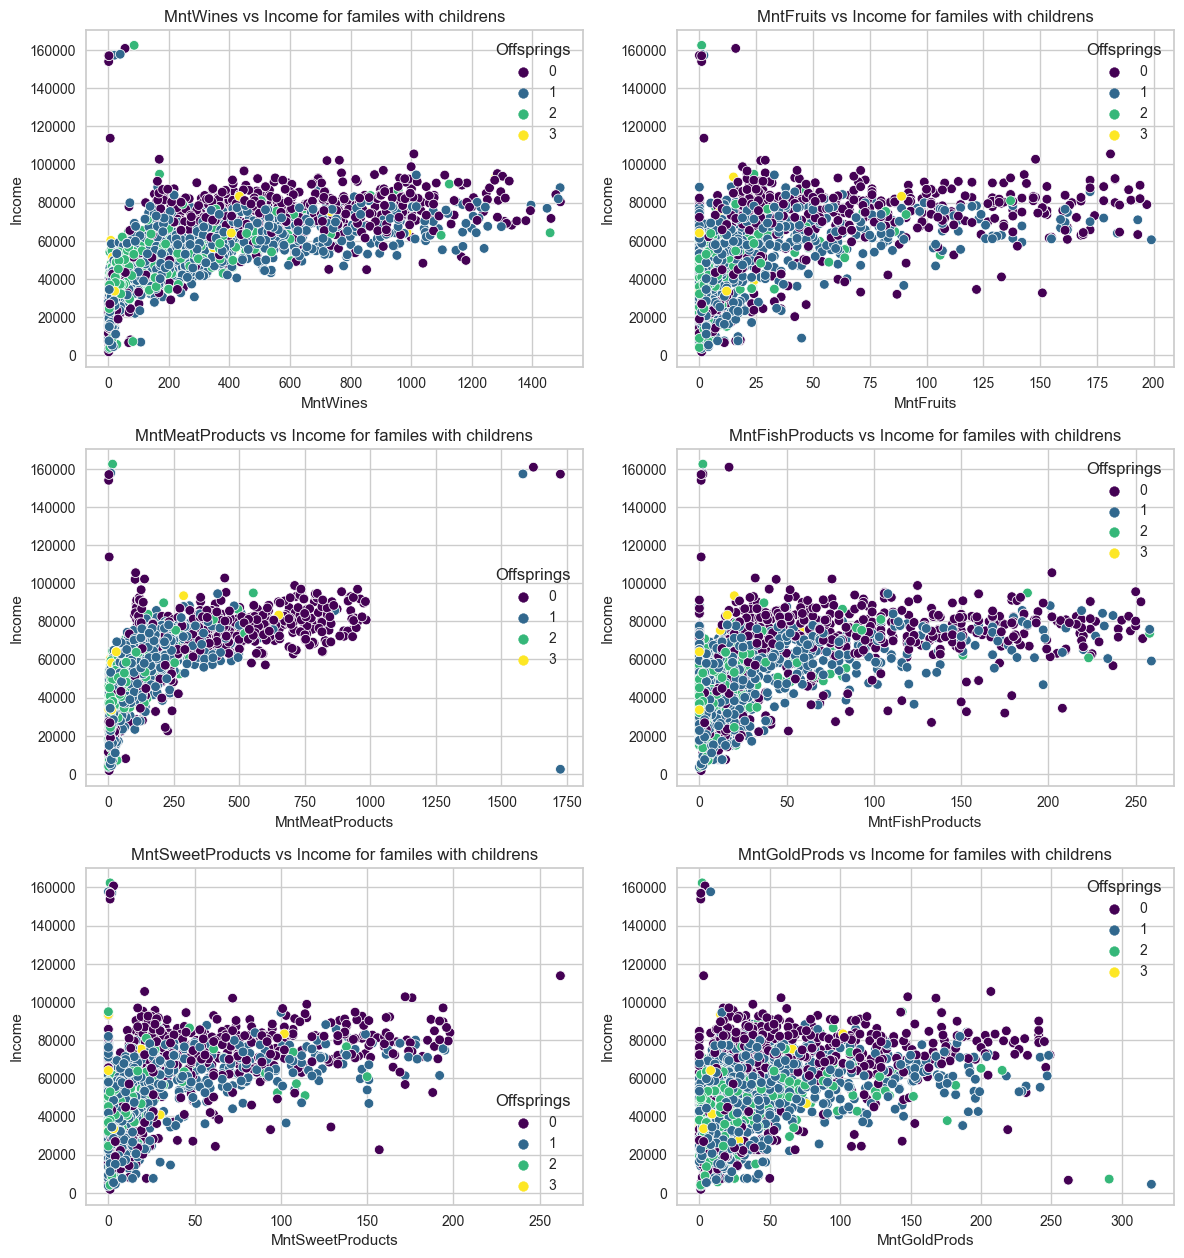

In [17]:
# Figure Settings
plt.subplots(figsize=(12, 50))

# Loop through each column in the list and plot graphs
for i, column in enumerate(encode_df[Mn_columns].columns):
    plt.subplot(len(encode_df.columns)//2 + 1, 2, i+1,)  # Create subplots
    sns.scatterplot(x= column , y='Income', hue="Offsprings", data=encode_df, palette='viridis')
    plt.title(column + " vs Income for familes with childrens")
    plt.tight_layout()

# Show the plot
plt.show()

In [18]:
# Gộp các cột MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds thành một cột mới là AmountSpent

encode_df['AmountSpent'] = encode_df['MntWines'] + encode_df['MntFruits'] + encode_df['MntMeatProducts'] + encode_df['MntFishProducts'] + encode_df['MntSweetProducts'] + encode_df['MntGoldProds']

encode_df = encode_df.drop(columns=Mn_columns)

<Axes: xlabel='AmountSpent', ylabel='Income'>

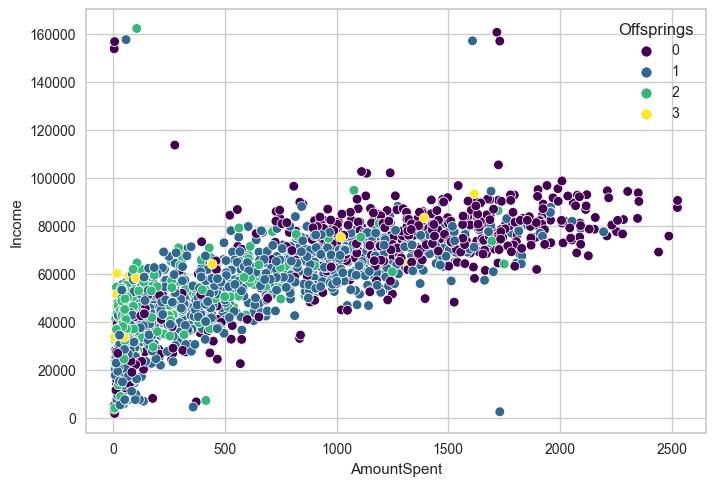

In [19]:
sns.scatterplot(x='AmountSpent', y='Income', hue='Offsprings', data=encode_df, palette='viridis')

### 2.4 Feature Scaling (chuẩn hóa các đặc trưng)

In [20]:
df = encode_df.copy()

In [21]:
scaled_columns = ['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',  'NumWebVisitsMonth', 'Age', 'Offsprings', 'AmountSpent', 'CustomerAge']

In [22]:
# Chuẩn hóa dữ liệu các cột
StdScl = StandardScaler()
scaledX = StdScl.fit_transform(encode_df[scaled_columns])
encode_df[scaled_columns] = scaledX

In [23]:
encode_df

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,2n Cycle,Basic,Graduation,Master,PhD,Couple,Offsprings,CustomerAge,AmountSpent
0,0.287105,0.310353,0.351030,1.426865,2.503607,-0.555814,0.692181,1.018352,0.0,0.0,1.0,0.0,0.0,0,-1.264598,1.527721,1.676245
1,-0.260882,-0.380813,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,0.0,0.0,1.0,0.0,0.0,0,1.404572,-1.189011,-0.963297
2,0.913196,-0.795514,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.0,0.0,1.0,0.0,0.0,1,-1.264598,-0.206048,0.280110
3,-1.176114,-0.795514,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,0.0,0.0,1.0,0.0,0.0,1,0.069987,-1.060584,-0.920135
4,0.294307,1.554453,1.390492,0.332600,0.111982,0.059532,-0.132545,-1.033114,0.0,0.0,0.0,0.0,1.0,1,0.069987,-0.951915,-0.307562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,0.430444,-0.104347,-0.168701,1.791619,0.111982,-0.555814,-0.132545,0.163575,0.0,0.0,1.0,0.0,0.0,1,0.069987,0.134778,1.218061
2208,0.560123,0.241237,2.429954,1.426865,-0.229679,-0.248141,0.692181,1.958607,0.0,0.0,0.0,0.0,1.0,1,2.739158,-1.653326,-0.271040
2209,0.233347,1.450778,-0.688432,-0.761665,0.111982,2.213242,0.279818,-1.033114,0.0,0.0,1.0,0.0,0.0,0,-1.264598,-0.981552,1.052052
2210,0.803172,-1.417564,-0.168701,0.697355,0.795303,1.290224,-0.957271,1.103830,0.0,0.0,0.0,1.0,0.0,1,0.069987,-0.976612,0.391336


<Axes: >

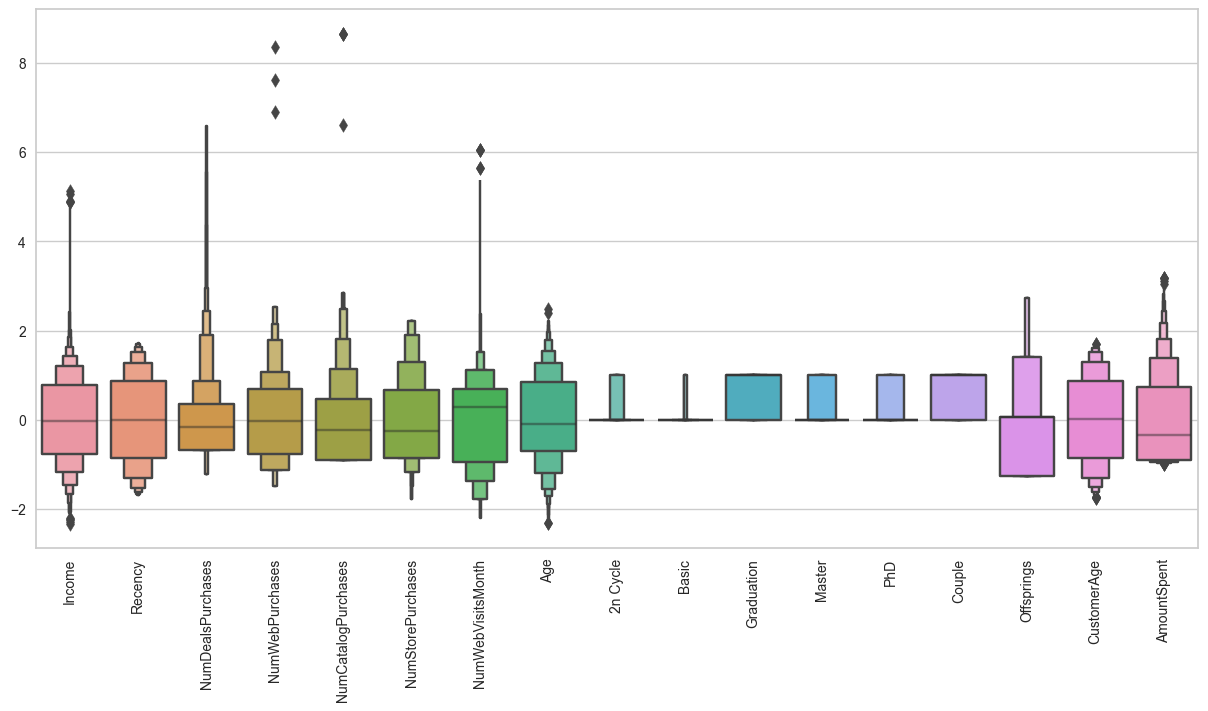

In [24]:
# Vẽ biểu đồ boxplot cho các feature
plt.figure(figsize=(15, 7))
plt.xticks(rotation=90)
sns.boxenplot(data=encode_df)

## 3, Thuật toán K-Means phương pháp chọn số cụm K

### 3.1 Giới thiệu thuật toán K-Means
- **K-Means** là thuật toán học máy không giám sát (tức là chưa biến nhãn đầu ra), thường được sử dụng khi muốn phân các điểm dữ liệu có sự tương đồng với nhau vào thành các cụm. Đây là thuật toán rất đơn giản và được sử dụng phổ biến rộng rãi, nó phân các điểm dữ liệu đầu vào thành **K cụm** (K được xác định trước). 
- **WCSS** viết tắt cho *Within-Cluster Sum of Squares* - là thước đo để đánh giá chất lượng của việc phân cụm. **WCSS** đo lường mức độ gần gũi hoặc chặt chẽ của các cụm bằng cách tính tổng bình phương khoảng cách giữa mỗi điểm dữ liệu và trọng tâm được gán của nó trong từng cụm.
- Mục tiêu của thuật toán là tối thiểu đại lượng **WCSS**. Giá trị **WCSS** nhỏ hơn tức là các điểm dữ liệu gần với trung tâm cụm của nó thuộc về hơn, dẫn đến các cụm gần gũi và tách biệt tốt hơn. Một cách để tối thiểu hóa đại lượng **WCSS** là chọn K (số cụm) sao cho **WCSS** giảm mà không dẫn đến overfitting.

### 3.1 Phương pháp chọn số K

**Phương pháp sử dụng:** `Elbow (khuỷu tay)`

In [28]:
scaledX = encode_df.copy()

In [29]:
# Tính WCSS khi số cụm là 1 đến 10
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++')
  kmeans.fit(scaledX)
  wcss.append(kmeans.inertia_)

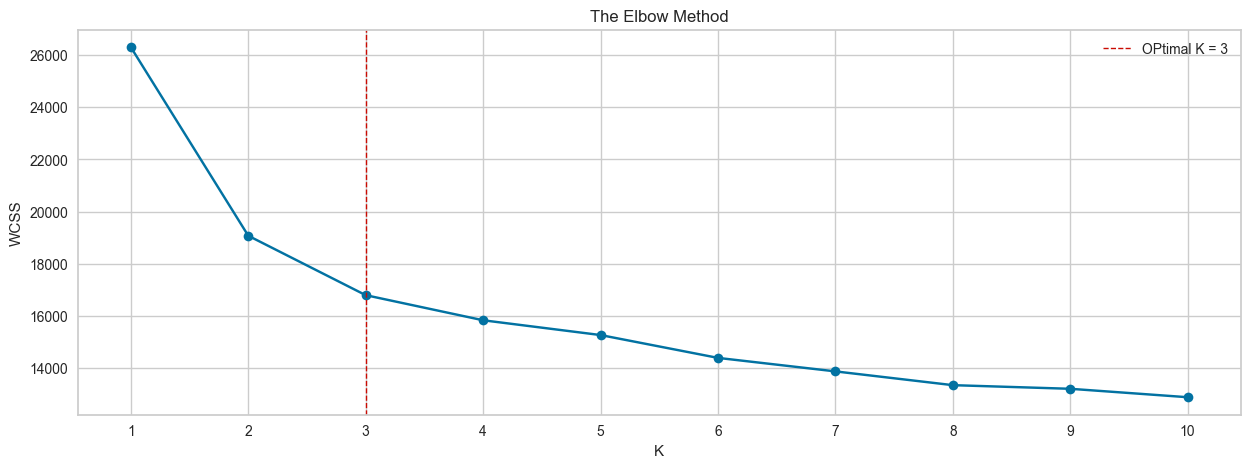

In [30]:
plt.figure(figsize=(15,5))

plt.xticks(np.arange(1,11,1))
plt.plot(range(1,11), wcss, marker='o', linestyle='-')

plt.title("The Elbow Method")
plt.xlabel("K")
plt.ylabel("WCSS")

plt.axvline(x=3, color='r', linestyle='--', linewidth=1, label='OPtimal K = 3')
plt.legend()

plt.show()

`Nhận xét:` Có thể thấy số cụm tối ưu là K = 3

- `Silhouette Score`: tính toán độ tương đồng của một điểm dữ liệu đối với cụm mà nó thuộc và độ khác biệt của nó so với các cụm khác.
- Giá trị silhouette score có thể nằm trong khoảng từ **-1 đến 1**. Một silhouette score gần 1 cho biết dữ liệu được phân chia tốt, trong khi một silhouette score gần -1 cho biết dữ liệu được phân chia không tốt. Nếu silhouette score gần 0, điều đó chỉ ra rằng các cụm có sự chồng chéo.

In [54]:
silhouette_scores = []

# Tính silhouette score cho mỗi số cụm từ 2 đến K_max
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaledX)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaledX, labels)
    silhouette_scores.append(silhouette_avg)

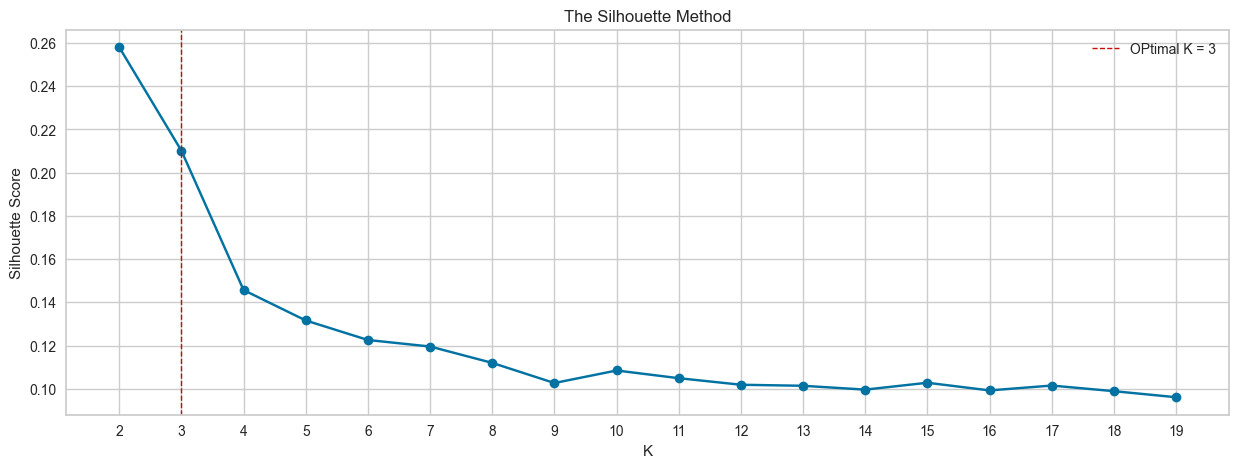

In [55]:
plt.figure(figsize=(15,5))

plt.xticks(np.arange(2,20,1))
plt.plot(range(2,20), silhouette_scores, marker='o', linestyle='-')

plt.title("The Silhouette Method")
plt.xlabel("K")
plt.ylabel("Silhouette Score")

plt.axvline(x=3, color='r', linestyle='--', linewidth=1, label='OPtimal K = 3')
plt.legend()

plt.show()

In [56]:
from sklearn.utils import shuffle

In [57]:
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(scaledX)
    score = silhouette_score(scaledX, labels)
    scores.append(score)

# Tạo ra một tập dữ liệu ngẫu nhiên
X_shuffled = shuffle(scaledX)

# Chạy K-means clustering với nhiều giá trị K trên tập dữ liệu ngẫu nhiên
scores_shuffled = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X_shuffled)
    score = silhouette_score(X_shuffled, labels)
    scores_shuffled.append(score)

# Tính toán gap statistic
gaps = []
for k in range(2, 10):
    gaps.append(scores_shuffled[k-2] - scores[k-2])

# Chọn giá trị K có gap statistic nhỏ nhất
k_optimal = gaps.index(min(gaps)) + 2

# In ra giá trị K tối ưu
print(f"Số cụm K tối ưu: {k_optimal}")

# In ra gap statistic cho mỗi giá trị K
for k, gap in enumerate(gaps):
    print(f"K = {k+2}: {gap}")

Số cụm K tối ưu: 4
K = 2: 5.551115123125783e-17
K = 3: 0.0
K = 4: -0.04196371498858295
K = 5: -0.014367669642500774
K = 6: 0.0011440432057858718
K = 7: -0.001576252659060251
K = 8: 0.0030864321537401734
K = 9: 0.01038452465927471


## 4, Huấn luyện mô hình và thực hiện phân cụm

In [61]:
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(scaledX)
Cluster = kmeans.labels_

In [62]:
df['Cluster'] = Cluster

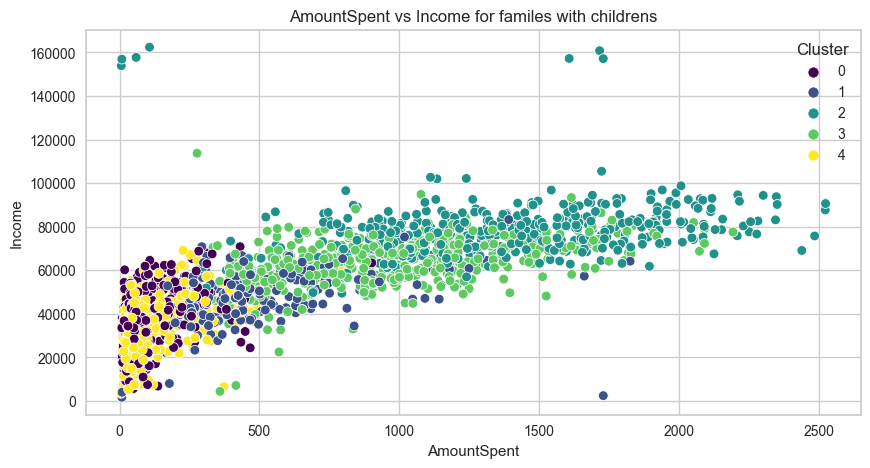

In [63]:
# Figure settings
plt.figure(figsize=(10,5))

# Create a scatter plot using Seaborn
sns.scatterplot(x='AmountSpent', y='Income', hue="Cluster", data=df, palette='viridis')

# Set the title and labels
plt.title('AmountSpent vs Income for familes with childrens')
plt.xlabel('AmountSpent')
plt.ylabel('Income')

# Show the plot
plt.show()

`Nhận xét:` chúng ta thấy rằng có 3 cụm
- Cụm 1: Nhóm thu nhập thấp, chi tiêu thấp
- Cụm 0: Nhóm thu nhập trung bình, chi tiêu trung bình
- Cụm 2: Nhóm thu nhập cao, chi tiêu cao

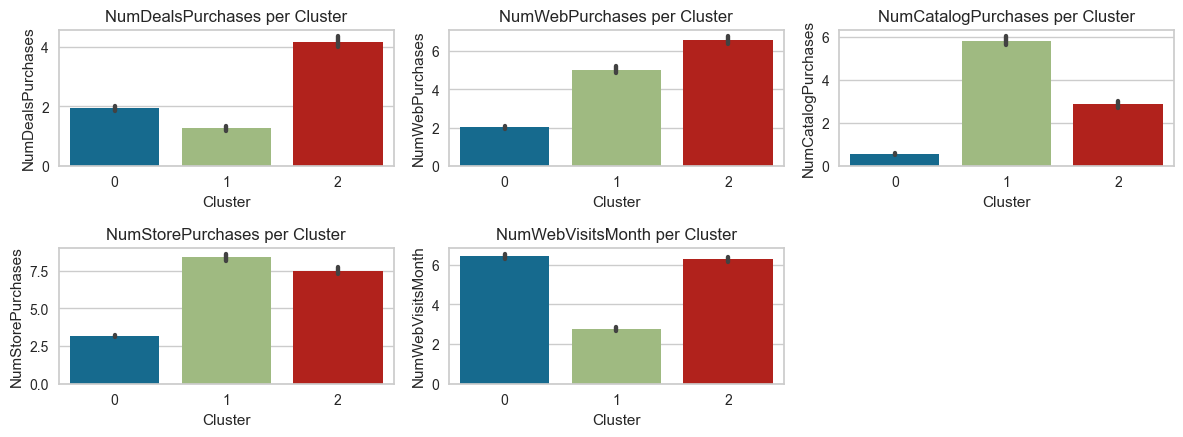

In [202]:
columnList = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

plt.figure(figsize=(12, 15))

for i, column in enumerate(columnList):
    plt.subplot(len(df.columns)//3 + 1, 3, i+1,)  # Create subplots
    sns.barplot(x='Cluster', y=column, data=df)
    plt.title(column + " per Cluster")
    plt.tight_layout()
plt.show()

In [203]:
df

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,2n Cycle,Basic,Graduation,Master,PhD,Couple,Offsprings,CustomerAge,AmountSpent,Cluster
0,58138.0,58,3,8,10,4,7,57,0.0,0.0,1.0,0.0,0.0,0,0,663,1617,1
1,46344.0,38,2,1,1,2,5,60,0.0,0.0,1.0,0.0,0.0,0,2,113,27,0
2,71613.0,26,1,8,2,10,4,49,0.0,0.0,1.0,0.0,0.0,1,0,312,776,1
3,26646.0,26,2,2,0,4,6,30,0.0,0.0,1.0,0.0,0.0,1,1,139,53,0
4,58293.0,94,5,5,3,6,5,33,0.0,0.0,0.0,0.0,1.0,1,1,161,422,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,61223.0,46,2,9,3,4,5,47,0.0,0.0,1.0,0.0,0.0,1,1,381,1341,2
2208,64014.0,56,7,8,2,5,7,68,0.0,0.0,0.0,0.0,1.0,1,3,19,444,2
2209,56981.0,91,1,2,3,13,6,33,0.0,0.0,1.0,0.0,0.0,0,0,155,1241,1
2210,69245.0,8,2,6,5,10,3,58,0.0,0.0,0.0,1.0,0.0,1,1,156,843,1


`Kết luận:`
- Nhóm thu nhập thấp, chi tiêu thấp (cụm 1) có lượt truy cập vào website nhất nhưng số lượt mua của nhóm này không nhiều bằng 2 nhóm còn lại nên chúng ta có thể bỏ qua nhóm này khi quảng cáo sản phẩm
- Nhóm thu nhập trung bình, chi tiêu trung bình (cụm 0) có số lượt truy cập vào website nhiều và lượng mua hàng ở cửa hàng và qua website cũng nhiều 
- Nhóm thu nhập cao, chi tiêu cao (cụm 2) có xu hướng mua hàng trực tiếp ở store vào theo danh mục, có một số lượng người nhỏ mua hàng qua website

In [204]:
df.head()

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,2n Cycle,Basic,Graduation,Master,PhD,Couple,Offsprings,CustomerAge,AmountSpent,Cluster
0,58138.0,58,3,8,10,4,7,57,0.0,0.0,1.0,0.0,0.0,0,0,663,1617,1
1,46344.0,38,2,1,1,2,5,60,0.0,0.0,1.0,0.0,0.0,0,2,113,27,0
2,71613.0,26,1,8,2,10,4,49,0.0,0.0,1.0,0.0,0.0,1,0,312,776,1
3,26646.0,26,2,2,0,4,6,30,0.0,0.0,1.0,0.0,0.0,1,1,139,53,0
4,58293.0,94,5,5,3,6,5,33,0.0,0.0,0.0,0.0,1.0,1,1,161,422,2


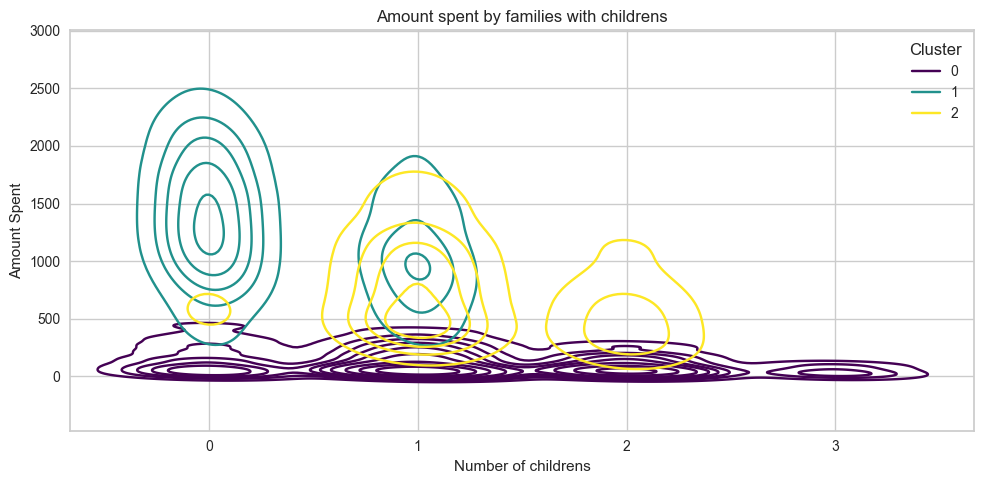

In [205]:
plt.figure(figsize=(10,5))
plt.xticks(np.arange(0,4,1))
sns.kdeplot(x='Offsprings', y='AmountSpent', hue="Cluster", data=df, palette='viridis')

# Set the title and labels
plt.title('Amount spent by families with childrens')
plt.xlabel('Number of childrens')
plt.ylabel('Amount Spent')

plt.tight_layout()

`Nhận xét:`
- Nhóm thu nhập cao, chi tiêu cao có từ 0-1 con nhưng chủ yếu là không có con
- Nhóm thu nhập trung bình, chi tiêu trung bình có từ 1-2 con
- Nhóm thu thu nhập thấp có xu hướng có nhiều con hơn 2 nhóm còn lại